In [39]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt
from torch.utils import data

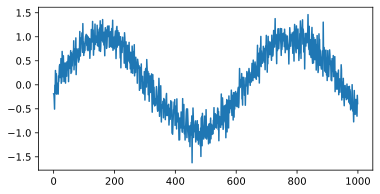

In [40]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
plt.plot(x)

We can map the data into features and labels based on embedding dimension $\tau$

In [41]:
tau = 4
features = torch.zeros(T - tau, tau)
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape(-1, 1)

batch_size = 16
n_train = 600

In [42]:
features

tensor([[-0.1900, -0.1865, -0.3072, -0.5061],
        [-0.1865, -0.3072, -0.5061, -0.0074],
        [-0.3072, -0.5061, -0.0074, -0.1879],
        ...,
        [-0.3067, -0.5800, -0.3070, -0.5789],
        [-0.5800, -0.3070, -0.5789, -0.6530],
        [-0.3070, -0.5789, -0.6530, -0.2207]])

In [43]:
dataset = data.TensorDataset(features[:n_train], labels[:n_train])
train_iter = data.DataLoader(dataset, batch_size, shuffle=True)

Construct a simple MLP structure.

In [44]:
net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))

def init_weight(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_uniform_(layer.weight)

net.apply(init_weight)
loss = nn.MSELoss(reduction='none')

In [45]:
lr = 0.01
epochs = 5
trainer = torch.optim.Adam(net.parameters(), lr)

for epoch in range(epochs):
    for x_, y in train_iter:
        trainer.zero_grad()
        y_hat = net(x_)
        l = loss(y_hat, y)
        l.sum().backward()
        trainer.step()
    print(f'Epoch: {epoch + 1}, loss: {d2l.evaluate_loss(net, train_iter, loss)}')

Epoch: 1, loss: 0.07525724607209365
Epoch: 2, loss: 0.060205876131852465
Epoch: 3, loss: 0.05869514569640159
Epoch: 4, loss: 0.05192789842685064
Epoch: 5, loss: 0.04947475776076317


## Prediction

Check how the net performs.

Use 1-step prediction first.

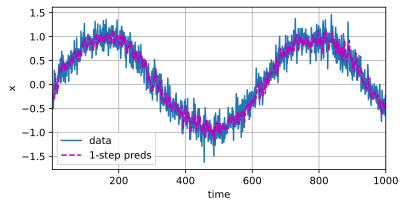

In [46]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()],
         'time', 'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

$k$-step-ahead-prediction: Use the prediction as a new input.

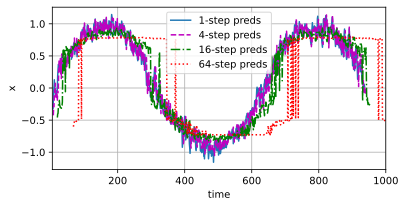

In [47]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau: i].reshape(1, -1)
    )

max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))


In [48]:
x

tensor([-1.8999e-01, -1.8648e-01, -3.0721e-01, -5.0611e-01, -7.4349e-03,
        -1.8790e-01,  2.9669e-01,  1.3491e-01,  3.0235e-02,  2.2989e-01,
        -1.9474e-01,  1.8611e-02, -1.0324e-01,  3.3876e-02,  2.5542e-02,
        -1.9315e-01,  1.8486e-01,  6.8950e-02,  2.1922e-01,  3.8629e-01,
         4.2091e-01,  2.8213e-01,  1.4923e-01,  2.2967e-01,  5.4521e-01,
         3.2277e-02,  3.9951e-01,  6.3077e-02,  6.9362e-01,  5.1502e-01,
         2.6273e-01,  1.6640e-01,  6.0358e-01,  3.6372e-01,  6.7887e-02,
         4.5253e-01,  2.2907e-01,  3.7050e-01,  4.2374e-01,  3.5505e-02,
         4.5473e-01,  3.9215e-01,  3.1178e-01,  1.7884e-01,  4.7919e-01,
         3.0925e-01,  4.4534e-01,  5.0195e-01,  6.1275e-01,  6.6507e-02,
         4.2432e-01,  5.8071e-01,  4.3789e-01,  3.3933e-01,  5.9807e-01,
         5.0777e-01,  7.0996e-01,  2.3681e-01,  6.7142e-01,  2.6382e-01,
         6.4100e-01,  3.9168e-01,  5.6340e-01,  6.0896e-01,  7.0222e-01,
         5.3814e-01,  9.1475e-01,  3.1234e-01,  4.9